# Van der Pol oscillator


The Van der Pol oscillator was introduced by the Dutch physicist Balthasar van der Pol.
This is a famous model, typically investigated in the study of nonlinear dynamics.
The model presents non-conservative oscillations with non-linear damping.
In the past, it has been of relevance in several practical problems of engineering such as
circuits containing vacuum tubes. For more information on the model see the wikipedia article
[Van der Pol oscillator](https://en.wikipedia.org/wiki/Van_der_Pol_oscillator).

In this notebook we compute the evolution of the limit cycle in the phase plane
for a set of initial conditions. For such set, we consider a *safety condition*
originally from [^ARCHCOMP19LIN], that aims at verifying that there is no solution
starting from the initial set that exceeds a prescribed upper bound on the
velocity $y(t) := x'(t)$ at all times in the given time span. Moreover, we also
illustrate the computation of an invariant set using the obtained flowipe.
Finally, we study the limit cycle à la Poincaré, by defining a function that computes
the cross section of the flowpipe at each revolution. Interestingly, this method
gives an algorithmic proof that the safety condition obtained previously is actually
verified at all times, i.e. over the unbounded time horizon $[0, \infty)$.

## Dynamics

The dynamics of the Van der Pol oscillator are described by the following ODE with
two variables:

$$
\begin{aligned}
  \dot{x} &= y \\
  \dot{y} &= \mu (1 - x^2) y - x
\end{aligned}
$$
The system has a stable limit cycle. Such limit cycle becomes increasingly sharp
for higher values of ``μ``. Here we consider the parameter ``μ = 1``.

In [1]:
using ReachabilityAnalysis, Plots

@taylorize function vanderpol!(dx, x, params, t)
    local μ = 1.0
    dx[1] = x[2]
    dx[2] = (μ * x[2]) * (1 - x[1]^2) - x[1]
    return dx
end

## Safety verification

We set the initial condition ``x(0) ∈ [1.25, 1.55]``, ``y(0) ∈ [2.35,2.45]``.
The *unsafe set* is given by ``y ≥ 2.75`` for a time span ``[0, 7]``.
In other words, we would like to prove that there doesn't exist a solution of
the model with a ``y`` value which is greater than 2.75, for any initial condition
on the given domain. The time horizon of ``T = 7`` is chosen such that the oscillator
can do at least one full cycle.

We proceed by defining the initial conditions as a hyperrectangular set according
to the problem's specifications. Then we build the initial-value problem and pass
it to the `solve` function. We specify using `TMJets` algorithm with default options.

In [2]:
X0 = Hyperrectangle(low=[1.25, 2.35], high=[1.55, 2.45])
prob = @ivp(x' = vanderpol!(x), dim=2, x(0) ∈ X0)
sol = solve(prob, T=7.0, alg=TMJets(abstol=1e-12));

For further computations, it is convenient to work with a [zonotopic](https://juliareach.github.io/ReachabilityAnalysis.jl/dev/man/basics/#Zonotopes-1)
overapproximation of the flowpipe.

In [3]:
solz = overapproximate(sol, Zonotope);

The maximum value of variable ``y`` is obtained by computing the [support function](https://juliareach.github.io/ReachabilityAnalysis.jl/dev/man/basics/#Representing-sets-with-support-functions-1)
of the flowpipe along direction ``[0, 1]``:

In [4]:
ρ([0.0, 1.0], solz)

2.7249775872233766

That shows that the property is satisfied. Below we plot the flowpipe in the
x-y plane, together with the horizontal line ``y = 2.75``.

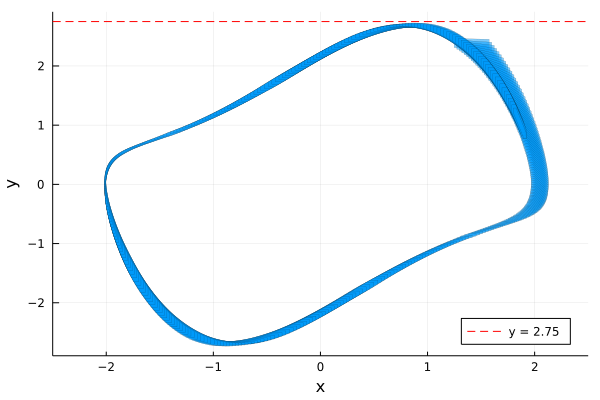

In [5]:
plot(solz, vars=(1, 2), lw=0.2, xlims=(-2.5, 2.5), xlab="x", ylab="y")
plot!(x -> 2.75, color=:red, lab="y = 2.75", style=:dash, legend=:bottomright)

We can also plot the state variables ``x(t)`` and ``y(t)`` as a function of time
(recall that `0` in `vars` is used to denote the time variable):

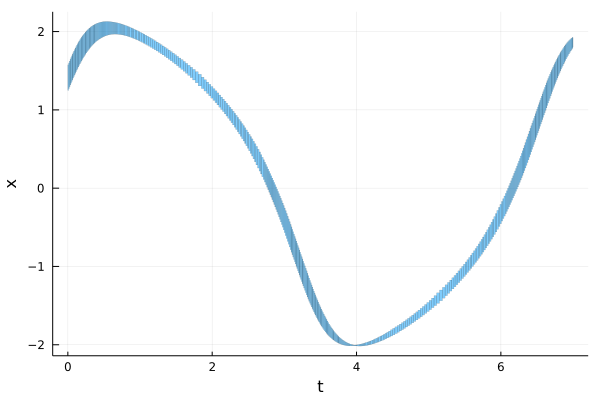

In [6]:
plot(solz, vars=(0, 1), lw=0.2, xlab="t", ylab="x")

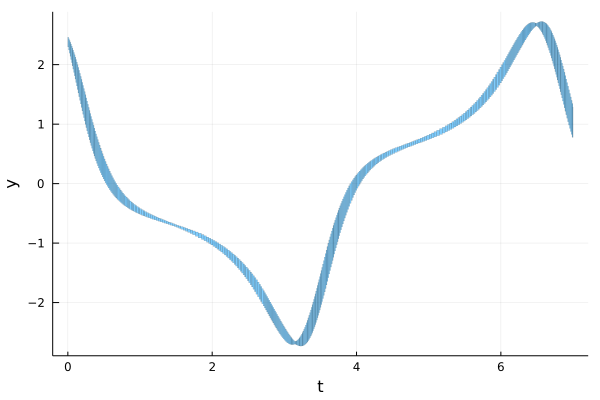

In [7]:
plot(solz, vars=(0, 2), lw=0.2,  xlab="t", ylab="y")

## Invariant Set

We can use the reachability result to examine an invariant of the system. In
other words, we can algorithmically prove that the flowpipe re-enters from where
it started after giving one loop, using inclusion checks.

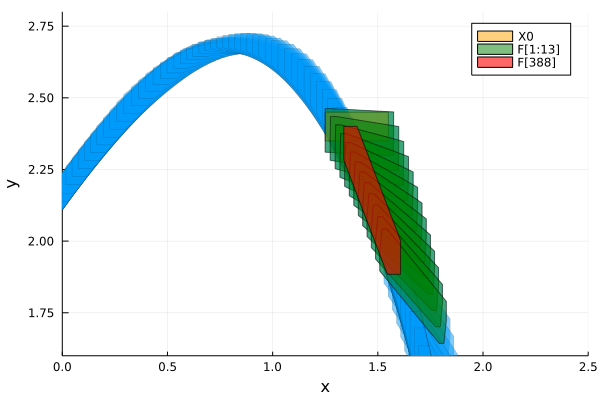

In [8]:
plot(solz, vars=(1, 2), lw=0.2, xlims=(0.0, 2.5), ylims=(1.6, 2.8), xlab="x", ylab="y")
plot!(X0, color=:orange, lab="X0")
plot!(solz[1:13], vars=(1, 2), color=:green, lw=1.0, alpha=0.5, lab="F[1:13]")
plot!(solz[388], vars=(1, 2), color=:red, lw=1.0, alpha=0.6, lab="F[388]")

It is seen that the reach-set corresponding to the time-span

In [9]:
tspan(solz[388])

[6.74967, 6.7599]

is included in the set union ``F[1] \cup \cdots \cup F[13]`` of previously
computed reach-sets. Notice that all future trajectories starting from
the 388-th reach-set are already covered by the flowpipe. Therefore, we can claim
that an *invariant set* was found.

## Limit cycle

To examine the limit cycle we can intersect a line segment perpendicular to the
flowpipe, that will allow us to get a cross-section of the sets in order to prove
that after one cycle the intersection segment actually shrinks. This approach
is similar to the method of [Poincaré sections](https://en.wikipedia.org/wiki/Poincar%C3%A9_map).

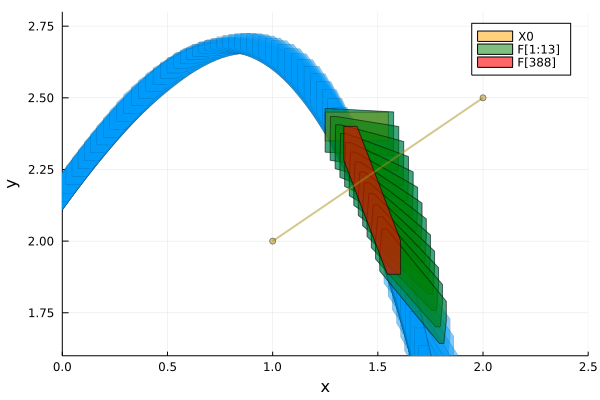

In [10]:
line = LineSegment([1, 2.], [2., 2.5])
plot(solz, vars=(1, 2), lw=0.2, xlims=(0.0, 2.5), ylims=(1.6, 2.8), xlab="x", ylab="y")
plot!(X0, color=:orange, lab="X0")
plot!(solz[1:13], vars=(1, 2), color=:green, lw=1.0, alpha=0.5, lab="F[1:13]")
plot!(solz[388], vars=(1, 2), color=:red, lw=1.0, alpha=0.6, lab="F[388]")
plot!(line, lw=2.0)

Then we can define a function to get the cross section of the flowpipe. The
function needs the flowpipe, a line segment that cuts the flowpipe and the
indices of the subsets to cut.

In [11]:
function cross_section(line::LineSegment, fp, idx)
    p = VPolygon()
    for i in idx
        x = intersection(line, set(fp[i]))
        if !isempty(x)
            p = convex_hull(p, x)
        end
    end
    vl = vertices_list(p)
    @assert length(vl) == 2
    return LineSegment(vl[1], vl[2])
end

cross_section (generic function with 1 method)

Then we can get the cross section of the first five sets and the last set,
calling them `i1` and `i2` respectively.

In [12]:
ifirst = cross_section(line, solz, 1:13)
ilast = cross_section(line, solz, [388])

LineSegment{Float64,Array{Float64,1}}([1.3848606487034292, 2.1924303243517143], [1.4836620847695106, 2.2418310423847556])

We can also calculate the length of each cross section, remember that the
system is 2D, so the cross section will be a line segment.

In [13]:
lfirst = norm(ifirst.q - ifirst.p)

0.2893075795381111

In [14]:
llast = norm(ilast.q - ilast.p);

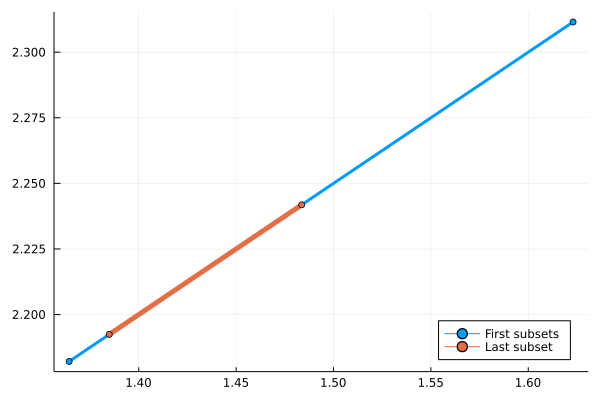

In [15]:
plot(ifirst, lw=3.0, alpha=1.0, label="First subsets", legend=:bottomright)
plot!(ilast, lw=5.0, alpha=1.0, label="Last subset")

The inclusion check succeeds:

In [16]:
ilast ⊆ ifirst

true

We can see, the cross section of the last subset is a subset of the first few
sets, thus, the cycle will continue, presumably getting smaller each revolution.

## References

[^ARCHCOMP19LIN]: Althoff, M., Bak, S., Forets, M., Frehse, G., Kochdumper, N., Ray, R., ... & Schupp, S. (2019, May). ARCH-COMP19 Category Report: Continuous and Hybrid Systems with Linear Continuous Dynamics. In ARCH@ CPSIoTWeek (pp. 14-40).